# Test Spot2vector on the AllenMsBrainAging(AMBA) MERFISH data

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Use cell type labels as ground truth

### Import data

In [2]:
adatast = sc.read_h5ad('./data/AMBA/preprocess_AMBA.h5ad')
adatast.obs['domain_annotation'] = adatast.obs['cell_type']

In [3]:
n_clusters = 10

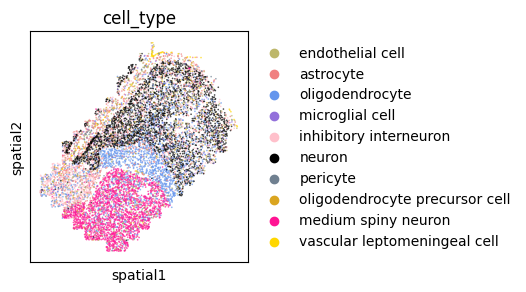

In [4]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adatast, color="cell_type", title="cell_type", 
              alpha=0.7, spot_size=30)

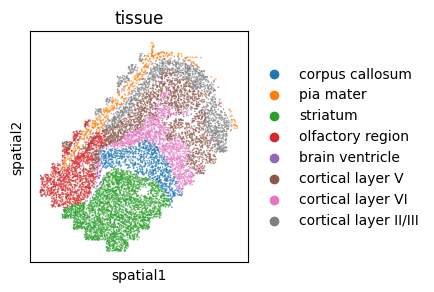

In [5]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adatast, color="tissue", title="tissue", 
              alpha=0.7, spot_size=30)

In [6]:
sc.pp.pca(adatast, n_comps=10)

### Run Spot2Vector

In [7]:
import Spot2Vector

Spot2Vector.Build_Graph(adatast, radius_cutoff=36, cutoff_type='radius', graph_type='spatial')
Spot2Vector.Build_Graph(adatast, neighbors_cutoff=8, cutoff_type='neighbors', graph_type='expression')

The spatial KNN grpah contains 9584 nodes and 50594.0 edges.(except self-loop)
Average degree of spatial graph: 5.28.
The expression KNN grpah contains 9584 nodes and 76672.0 edges.(except self-loop)
Average degree of expression graph: 8.00.


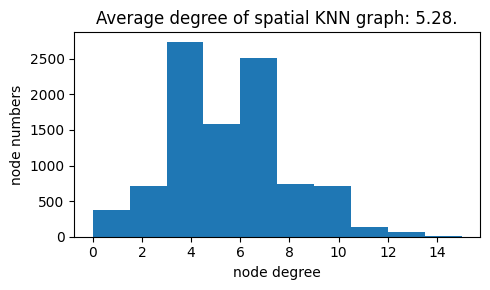

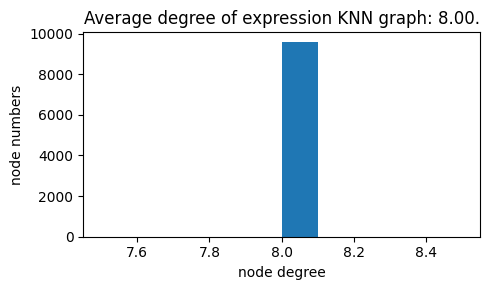

In [8]:
Spot2Vector.Graph_Stat_Plot(adatast)

In [9]:
device = 'cuda:1'
Spot2Vector.Fit(adatast, verbose=False, seed=10, device=device, max_epochs_st=1000)

Training: 100%|██████████| 1000/1000 [05:27<00:00,  3.05epoch/s, epoch=999, loss=1.194, lr=0.0001]


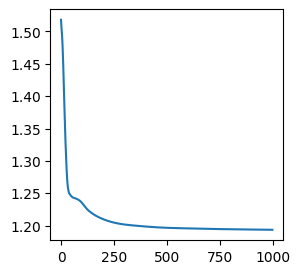

In [10]:
plt.plot(adatast.uns['training_history_df_st']['loss_ZINB'])

### Clustering

In [11]:
clust_method = 'mclust'

In [12]:
Spot2Vector.Clustering(adatast, obsm_data='exp_embeddings', method = clust_method, n_cluster=n_clusters, verbose=False)
Spot2Vector.Clustering(adatast, obsm_data='spa_embeddings', method = clust_method, n_cluster=n_clusters, verbose=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [13]:
# lamda = 1 for expression, lamda = 0 for spatial
Spot2Vector.Infer(adatast, lamda=0.8, device=device)

In [14]:
Spot2Vector.Clustering(adatast, obsm_data='embeddings', method=clust_method, n_cluster=n_clusters, verbose=False)

fitting ...
  |======================================================================| 100%


In [15]:
Spot2Vector.Clustering_Metrics(adatast, f'embeddings_{clust_method}')

ARI of embeddings_mclust is: 0.9470802282665447
NMI of embeddings_mclust is: 0.929261119858837


### Visualization

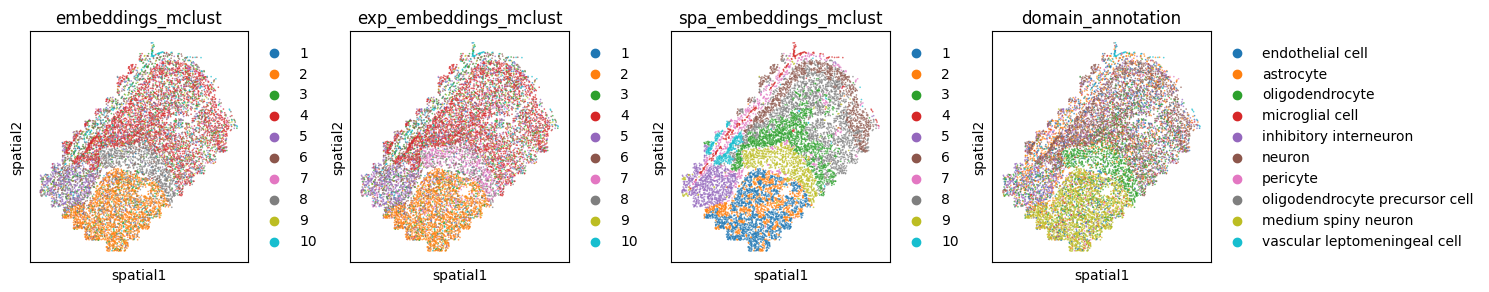

In [16]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adatast,
              color=[f"embeddings_{clust_method}",
                     f"exp_embeddings_{clust_method}", 
                     f"spa_embeddings_{clust_method}", 
                     "domain_annotation"], 
              title=[f"embeddings_{clust_method}",
                     f"exp_embeddings_{clust_method}", 
                     f"spa_embeddings_{clust_method}", 
                     "domain_annotation"], 
              alpha=0.7,
              spot_size=30)

In [17]:
sc.pp.neighbors(adatast, use_rep='embeddings')
sc.tl.umap(adatast)

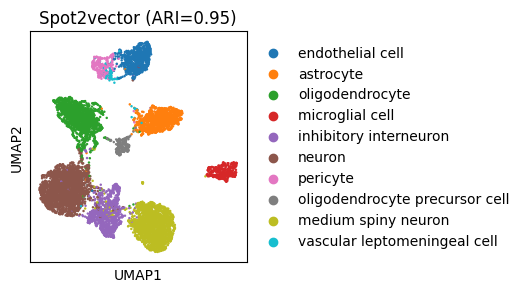

In [18]:
plt.rcParams["figure.figsize"] = (2.8, 3)
sc.pl.umap(adatast, color='Ground Truth', 
           title='Spot2vector (ARI=' + str(np.round(adatast.uns['embeddings_mclust_ARI'], 2)) + ')',
           save='AMBA_CT_Spot2vector.svg')

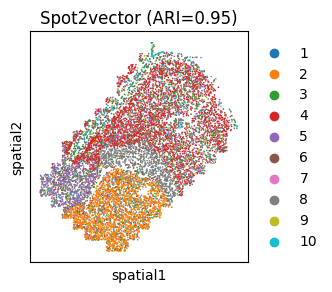

In [19]:
plt.rcParams["figure.figsize"] = (10, 3)
sc.pl.spatial(adatast, color=f"embeddings_{clust_method}", 
              title='Spot2vector (ARI=' + str(np.round(adatast.uns['embeddings_mclust_ARI'], 2)) + ')',
              spot_size=30,
              save='AMBA_CT_Spot2vector.svg')

## 2. Use domain labels as ground truth

### Clustering

In [20]:
n_clusters = 8
adatast.obs['domain_annotation'] = adatast.obs['tissue']

In [21]:
Spot2Vector.Clustering(adatast, obsm_data='exp_embeddings', method=clust_method, n_cluster=n_clusters, verbose=False)
Spot2Vector.Clustering(adatast, obsm_data='spa_embeddings', method=clust_method, n_cluster=n_clusters, verbose=False)

fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%


In [22]:
# lamda = 1 for expression, lamda = 0 for spatial
Spot2Vector.Infer(adatast, lamda=0, device=device)

In [23]:
Spot2Vector.Clustering(adatast, obsm_data='embeddings', method=clust_method, n_cluster=n_clusters, verbose=False)
Spot2Vector.Clustering_Metrics(adatast, f'embeddings_{clust_method}')

fitting ...
  |======================================================================| 100%
ARI of embeddings_mclust is: 0.657647706621692
NMI of embeddings_mclust is: 0.657061969534862


### Visualization

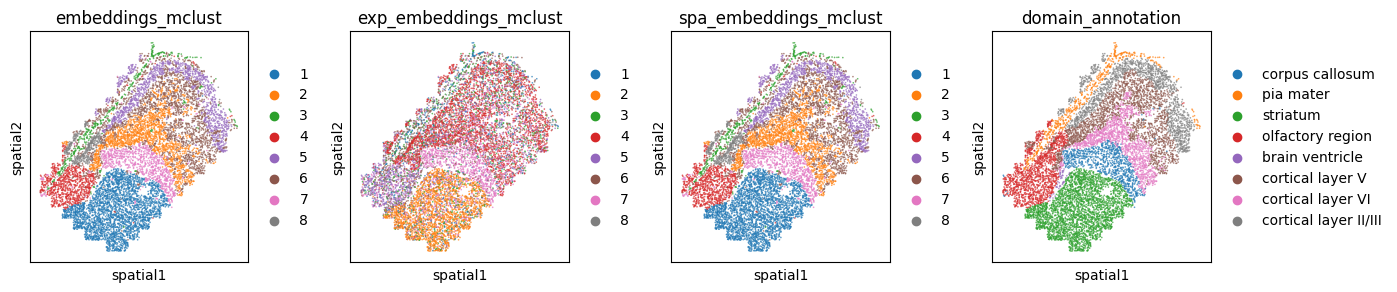

In [24]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adatast,
              color=[f"embeddings_{clust_method}",
                     f"exp_embeddings_{clust_method}", 
                     f"spa_embeddings_{clust_method}", 
                     "domain_annotation"], 
              title=[f"embeddings_{clust_method}",
                     f"exp_embeddings_{clust_method}", 
                     f"spa_embeddings_{clust_method}", 
                     "domain_annotation"], 
              alpha=0.7,
              spot_size=30)

In [25]:
sc.pp.neighbors(adatast, use_rep='embeddings')
sc.tl.umap(adatast)

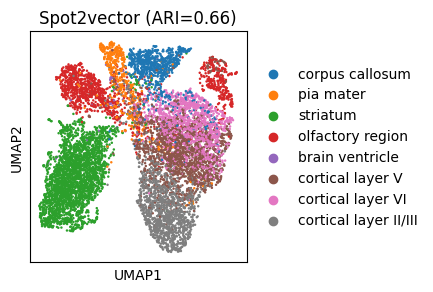

In [26]:
plt.rcParams["figure.figsize"] = (2.8, 3)
sc.pl.umap(adatast, color='domain_annotation', 
           title='Spot2vector (ARI=' + str(np.round(adatast.uns['embeddings_mclust_ARI'], 2)) + ')',
           save='AMBA_Domain_Spot2vector.svg')

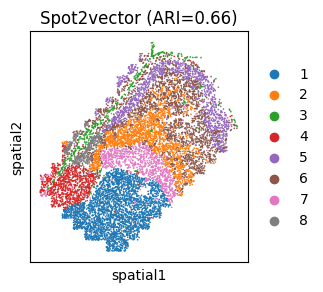

In [27]:
plt.rcParams["figure.figsize"] = (10, 3)
sc.pl.spatial(adatast, color=f"embeddings_{clust_method}", 
              title='Spot2vector (ARI=' + str(np.round(adatast.uns['embeddings_mclust_ARI'], 2)) + ')',
              spot_size=30,
              save='AMBA_Domain_Spot2vector.svg')